# Experimenting with Prophet

This notebook demonstrates how to download and transform stock data for use with Prophet.

In [95]:
import yfinance as yf
import pandas as pd 
import plotly.graph_objects as go
from prophet import Prophet

# Dynamic graphs 
from prophet.plot import plot_plotly, plot_components_plotly

In [96]:
# Check the version of Prophet
import prophet
prophet.__version__

'1.1.6'

In [97]:

def download_stock_data(ticker_symbol):
    """
    Download stock data with error handling and validation
    """
    try:
        # Create ticker object and get history
        yticker = yf.Ticker(ticker_symbol)
        df = yticker.history(period='max')
        
        if df.empty:
            raise ValueError(f"No data downloaded for {ticker_symbol}")
            
        print(f"Downloaded {len(df)} days of {ticker_symbol} data")
        
        # Basic validation
        required_columns = ['Open', 'Close', 'Volume']
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
            
        return df
    
    except Exception as e:
        print(f"Error downloading {ticker_symbol}: {str(e)}")
        return None

def transform_stock_data(df, ticker):
    """
    Transform stock data for Prophet model
    """
    if df is None:
        return None
    
    # Reset index to make the date a column
    df = df.reset_index()
    
    # Prophet requires columns named 'ds' (date) and 'y' (target)
    prophet_df = pd.DataFrame()
    prophet_df['ds'] = pd.to_datetime(df['Date']).dt.tz_localize(None)  # Remove timezone
    prophet_df['y'] = df['Close'].astype(float)    # Ensure float
    
    # Add additional features as regressors
    prophet_df['volume'] = df['Volume'].astype(float)
    prophet_df['open'] = df['Open'].astype(float)
    
    # Calculate returns
    prophet_df['returns'] = prophet_df['y'].pct_change()
    
    # Calculate moving averages
    prophet_df['ma20'] = prophet_df['y'].rolling(window=20).mean()
    prophet_df['ma50'] = prophet_df['y'].rolling(window=50).mean()
    
    # Calculate volatility (20-day rolling standard deviation)
    prophet_df['volatility'] = prophet_df['y'].rolling(window=20).std()
    
    # Add day of week as a feature
    prophet_df['day_of_week'] = prophet_df['ds'].dt.dayofweek
    
    # Fill any missing values
    prophet_df = prophet_df.ffill()

    # important! all stats should be filled Forward fill + Backward fill (most conservative)
    prophet_df['volume'] = prophet_df['volume'].fillna(method='ffill').fillna(method='bfill')
    prophet_df['volatility'] = prophet_df['volatility'].fillna(method='ffill').fillna(method='bfill')


    return prophet_df

## Download Stock Data

In [98]:
# Download data for QQQ
ticker = "QQQ"
df = download_stock_data(ticker)

print("\nRaw data sample:")
df.head()

Downloaded 6522 days of QQQ data

Raw data sample:


Open       High        Low      Close  \
Date                                                                    
1999-03-10 00:00:00-05:00  43.400442  43.426971  42.684176  43.347385   
1999-03-11 00:00:00-05:00  43.665726  43.917746  42.710704  43.559612   
1999-03-12 00:00:00-05:00  43.400455  43.426983  42.153620  42.498489   
1999-03-15 00:00:00-05:00  42.816819  43.771841  42.365837  43.718784   
1999-03-16 00:00:00-05:00  43.904477  44.275874  43.426966  44.090176   

                            Volume  Dividends  Stock Splits  Capital Gains  
Date                                                                        
1999-03-10 00:00:00-05:00  5232000        0.0           0.0            0.0  
1999-03-11 00:00:00-05:00  9688600        0.0           0.0            0.0  
1999-03-12 00:00:00-05:00  8743600        0.0           0.0            0.0  
1999-03-15 00:00:00-05:00  6369000        0.0           0.0            0.0  
1999-03-16 00:00:00-05:00  4905800        0.0           0.0            0.0

## Transform Data for Prophet

Prophet requires specific column names (read docs here: https://facebook.github.io/prophet/docs/quick_start.html):
- 'ds': date column (should be without timezone)
- 'y': target variable

We'll also add additional features as regressors.

In [99]:
# Transform data into Prophet format
prophet_df = transform_stock_data(df, ticker)

# !! No Saturdays and Sundays (day_of_week !=5,6)
print("\nTransformed data sample (Prophet format):")
prophet_df.tail(10)


Transformed data sample (Prophet format):


/var/folders/_6/616g1v7j04jdsf8gy64v_t640000gn/T/ipykernel_32672/1031863534.py:63: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/var/folders/_6/616g1v7j04jdsf8gy64v_t640000gn/T/ipykernel_32672/1031863534.py:64: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



ds           y      volume        open   returns        ma20  \
6512 2025-01-28  521.809998  33194200.0  515.219971  0.014780  517.857503   
6513 2025-01-29  520.830017  26649000.0  522.460022 -0.001878  517.771004   
6514 2025-01-30  523.049988  27431300.0  523.710022  0.004262  518.143004   
6515 2025-01-31  522.289978  38845500.0  526.919983 -0.001453  518.696002   
6516 2025-02-03  518.109985  40580800.0  513.469971 -0.008003  519.090001   
6517 2025-02-04  524.469971  26046800.0  518.630005  0.012275  519.384499   
6518 2025-02-05  526.849976  21134100.0  521.820007  0.004538  519.499998   
6519 2025-02-06  529.599976  19434500.0  527.359985  0.005220  520.220998   
6520 2025-02-07  522.919983  29605500.0  530.140015 -0.012613  520.603496   
6521 2025-02-10  529.250000  20757800.0  527.219971  0.012105  521.706496   

            ma50  volatility  day_of_week  
6512  516.798906    8.196487            1  
6513  516.987000    8.153263            2  
6514  517.290578    8.218939            3  
6515  517.820966    8.100552            4  
6516  518.198866    7.855021            0  
6517  518.635276    7.944794            1  
6518  519.125076    8.039909            2  
6519  519.633735    8.275242            3  
6520  519.992620    8.210902            4  
6521  520.462132    7.784828            0

## Available Features

Let's look at all the features we've created for Prophet:

In [100]:
print("Available features:")
prophet_df.columns.tolist()

Available features:


['ds',
 'y',
 'volume',
 'open',
 'returns',
 'ma20',
 'ma50',
 'volatility',
 'day_of_week']

# Predict with Prophet
* Simple to use, but mostly black box approach
* "By default, Prophet uses a linear model for its forecast."
* [Ivan] Good for long-term trend undestanding, but not for the short-term
* Automatic changepoint detection in Prophet

In [101]:
def predict_with_prophet(df:pd.DataFrame, periods=365, seasonality_mode= None, seasonality = None, country_holidays=None, changepoints=None, regressors=None):
       
    if seasonality_mode is None and changepoints is None:
        m = Prophet()
    elif seasonality_mode is not None and changepoints is None:
        m = Prophet(seasonality_mode='multiplicative')
    elif seasonality_mode is None and changepoints is not None:
        m = Prophet(changepoints=changepoints)
    else:
        m = Prophet(seasonality_mode='multiplicative', changepoints=changepoints)

    #weekly, monthly seasonality? 
    if seasonality is not None:
        m.add_seasonality(name=seasonality, period=30.5, fourier_order=5)
    
    if country_holidays is not None:
        m.add_country_holidays(country_name='US')
    
    if regressors is not None:
        for r in regressors:
            m.add_regressor(r)

    # Fit
    m.fit(df)

    # Make dates for prediction
    future = m.make_future_dataframe(periods=periods)

    # Remove weekends using pandas datetime weekday
    future = future[future['ds'].dt.dayofweek < 5]  # 5 = Saturday, 6 = Sunday
    
    forecast = m.predict(future)
    # forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
       
    return m, forecast


## 1. Simple prediction


In [102]:
m, forecast = predict_with_prophet(df=prophet_df)

# graphs 
plot_plotly(m, forecast)

09:41:14 - cmdstanpy - INFO - Chain [1] start processing
09:41:15 - cmdstanpy - INFO - Chain [1] done processing


In [103]:
plot_components_plotly(m, forecast)

In [104]:
# Forecast is an interval!
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
6778 2026-02-04  516.169186  487.430777  542.396011
6779 2026-02-05  516.346515  489.476602  545.177155
6780 2026-02-06  516.358980  487.615123  543.294952
6781 2026-02-09  516.924430  486.892271  543.226012
6782 2026-02-10  516.710705  489.646983  545.587547

## 2. Add seasonality_mode


In [105]:
m, forecast = predict_with_prophet(df=prophet_df, seasonality_mode='multiplicative')

# graphs 
plot_plotly(m, forecast)

09:41:15 - cmdstanpy - INFO - Chain [1] start processing
09:41:18 - cmdstanpy - INFO - Chain [1] done processing


## 3. Add US Holidays

In [106]:
m, forecast = predict_with_prophet(df=prophet_df, seasonality_mode='multiplicative', country_holidays='US')

# graphs 
plot_plotly(m, forecast)

09:41:18 - cmdstanpy - INFO - Chain [1] start processing
09:41:20 - cmdstanpy - INFO - Chain [1] done processing


In [107]:
plot_components_plotly(m, forecast)

In [108]:
m.train_holiday_names


0                                      New Year's Day
1                           New Year's Day (observed)
2                                        Memorial Day
3                                    Independence Day
4                         Independence Day (observed)
5                                           Labor Day
6                                        Veterans Day
7                                        Thanksgiving
8                                       Christmas Day
9                            Christmas Day (observed)
10                         Martin Luther King Jr. Day
11                              Washington's Birthday
12                                       Columbus Day
13                            Veterans Day (observed)
14               Juneteenth National Independence Day
15    Juneteenth National Independence Day (observed)
dtype: object

## 4. Add Changepoints

In [109]:
# https://en.wikipedia.org/wiki/List_of_largest_daily_changes_in_the_S%26P_500_Index
# Select all dates with daily change >10% (up or down)
changepoints = ['2008-10-13','2020-03-16']

m, forecast = predict_with_prophet(df=prophet_df, 
                                   seasonality_mode='multiplicative', 
                                   country_holidays='US',
                                   changepoints=changepoints)

# graphs 
plot_plotly(m, forecast)

09:41:21 - cmdstanpy - INFO - Chain [1] start processing
09:41:21 - cmdstanpy - INFO - Chain [1] done processing


In [110]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds        yhat  yhat_lower  yhat_upper
6778 2026-02-04  554.190001  517.690163  589.892246
6779 2026-02-05  554.948120  519.748074  591.133740
6780 2026-02-06  554.413183  518.469715  587.958250
6781 2026-02-09  555.453744  522.569194  593.035232
6782 2026-02-10  554.158617  519.947943  588.552665

In [111]:
# Old static graphs instead of the dynamic
# fig1 = m.plot(forecast)
# fig2 = m.plot_components(forecast)

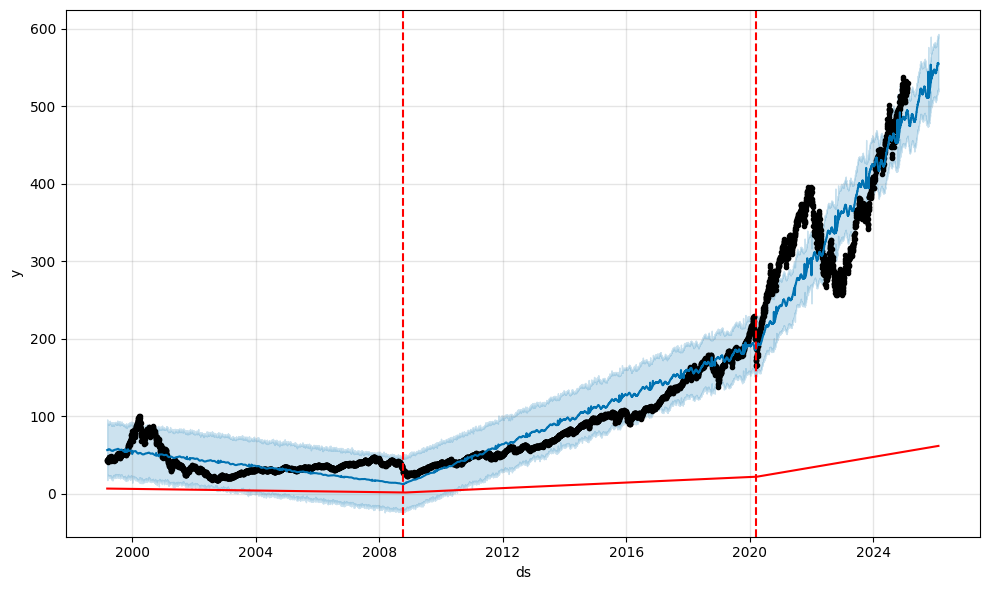

In [112]:
# Automatic changepoints identification
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


## 5. Add Regressors

In [113]:
prophet_df.tail()

ds           y      volume        open   returns        ma20  \
6517 2025-02-04  524.469971  26046800.0  518.630005  0.012275  519.384499   
6518 2025-02-05  526.849976  21134100.0  521.820007  0.004538  519.499998   
6519 2025-02-06  529.599976  19434500.0  527.359985  0.005220  520.220998   
6520 2025-02-07  522.919983  29605500.0  530.140015 -0.012613  520.603496   
6521 2025-02-10  529.250000  20757800.0  527.219971  0.012105  521.706496   

            ma50  volatility  day_of_week  
6517  518.635276    7.944794            1  
6518  519.125076    8.039909            2  
6519  519.633735    8.275242            3  
6520  519.992620    8.210902            4  
6521  520.462132    7.784828            0

In [114]:
# https://en.wikipedia.org/wiki/List_of_largest_daily_changes_in_the_S%26P_500_Index
# Select all dates with daily change >10% (up or down)
changepoints = ['2008-10-13','2020-03-16']

m, forecast = predict_with_prophet(df=prophet_df, 
                                   seasonality_mode='multiplicative', 
                                   country_holidays='US',
                                   changepoints=changepoints,
                                   regressors=['volatility'])

# graphs 
plot_plotly(m, forecast)

09:41:23 - cmdstanpy - INFO - Chain [1] start processing
09:41:23 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Regressor 'volatility' missing from dataframe

In [ ]:
help(Prophet.add_regressor) 

Help on function add_regressor in module prophet.forecaster:

add_regressor(self, name, prior_scale=None, standardize='auto', mode=None)
    Add an additional regressor to be used for fitting and predicting.

    The dataframe passed to `fit` and `predict` will have a column with the
    specified name to be used as a regressor. When standardize='auto', the
    regressor will be standardized unless it is binary. The regression
    coefficient is given a prior with the specified scale parameter.
    Decreasing the prior scale will add additional regularization. If no
    prior scale is provided, self.holidays_prior_scale will be used.
    Mode can be specified as either 'additive' or 'multiplicative'. If not
    specified, self.seasonality_mode will be used. 'additive' means the
    effect of the regressor will be added to the trend, 'multiplicative'
    means it will multiply the trend.

    Parameters
    ----------
    name: string name of the regressor.
    prior_scale: optional flo

In [ ]:
help(Prophet.fit)

Help on function fit in module prophet.forecaster:

fit(self, df, **kwargs)
    Fit the Prophet model.

    This sets self.params to contain the fitted model parameters. It is a
    dictionary parameter names as keys and the following items:
        k (Mx1 array): M posterior samples of the initial slope.
        m (Mx1 array): The initial intercept.
        delta (MxN array): The slope change at each of N changepoints.
        beta (MxK matrix): Coefficients for K seasonality features.
        sigma_obs (Mx1 array): Noise level.
    Note that M=1 if MAP estimation.

    Parameters
    ----------
    df: pd.DataFrame containing the history. Must have columns ds (date
        type) and y, the time series. If self.growth is 'logistic', then
        df must also have a column cap that specifies the capacity at
        each ds.
    kwargs: Additional arguments passed to the optimizing or sampling
        functions in Stan.

    Returns
    -------
    The fitted Prophet object.

